# Import dependencies

In [1]:
!pip install torchtext --upgrade
!python -m spacy download fr
!python -m spacy download en

Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.5.0)
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [0]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download data

In [0]:
if not os.path.exists('./data'):
    !mkdir ./data

In [5]:
!wget --no-check-certificate \
    http://www.statmt.org/europarl/v7/fr-en.tgz \
    -O ./data/fr-en.tgz

--2020-03-18 05:07:11--  http://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘./data/fr-en.tgz’

./data/fr-en.tgz    100%[===================>] 193.33M   975KB/s    in 3m 53s  

2020-03-18 05:11:05 (849 KB/s) - ‘./data/fr-en.tgz’ saved [202718517/202718517]



In [6]:
!tar -xzvf ./data/fr-en.tgz -C ./data

europarl-v7.fr-en.en
europarl-v7.fr-en.fr


# Data processing

In [0]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise NotImplementedError(f'File {filepath} doesn\'t exist')

In [0]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = unicode_to_ascii(s.strip())
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [5]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs)}')
pairs = np.random.choice(pairs, size=3000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs)}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples: 2007723
Number of examples after sampling: 3000
Example:
	FR => Les procedures par le biais desquelles de tels produits entrent et sortent de l'Union europeenne doivent etre ouvertes, transparentes et, par dessus tout, sures.
	EN => The procedures whereby such products come in and out of the European Union have to be open, transparent and, above all, safe.
CPU times: user 3.73 s, sys: 1.03 s, total: 4.76 s
Wall time: 16.5 s


In [6]:
%%time
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr')
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.7, 0.2, 0.1])
print(f'train size: {len(train_data.examples)}')
print(f'valid size: {len(valid_data.examples)}')
print(f'test size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

100%|██████████| 3000/3000 [00:01<00:00, 2383.47it/s]

train size: 2100
valid size: 300
test size: 600
{'src': ['.', 'rester', 'de', 'permettant', 'leur', 'integration', "'", 'd', 'politique', 'une', 'prioritairement', 'place', 'en', 'mettre', 'faut', 'il', "'", 'qu', 'et', ',', '"', 'union', "'", 'l', 'de', 'citoyens', 'des', 'ceux', 'de', 'possible', 'que', 'proches', 'aussi', 'uniformes', 'droits', 'de', 'ensemble', 'un', '"', ':', 'cite', 'je', ',', 'legaux', 'immigres', 'aux', 'donner', 'faut', 'il', "'", 'qu', ',', 'reprises', 'plusieurs', 'a', ',', 'fortement', 'proclame', 'il', ',', 'temps', 'meme', 'en', 'mais', ',', 'source', 'la', 'a', 'clandestine', 'immigration', "'", 'l', 'combattre', 'de', 'et', 'migratoires', 'flux', 'les', 'gerer', 'de', 'platonique', 'volonte', 'la', 'affiche', 'tampere', 'de', 'conseil', 'le', ':', 'contradiction', 'seconde'], 'dest': ['.', 'stay', 'to', 'them', 'enable', 'to', 'up', 'set', 'be', 'must', 'integration', 'of', 'policy', 'a', 'priority', 'a', 'as', 'that', 'and', ',', '"', 'citizens', 'eu',

In [7]:
FR.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab)}')
print(f'Length of EN vocabulary: {len(EN.vocab)}')

Length of FR vocabulary: 3472
Length of EN vocabulary: 3110


# Modeling

## Encoder

In [0]:
class Encoder(nn.Module):

    def __init__(self, embed_size, vocab_size, hidden_size,
                 n_layers=1, dropout=0, bidirectional=True):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(dropout if n_layers > 1 else 0),
                            bidirectional=bidirectional)
    
    def forward(self, in_):
        """
        inputs
            in_: (seq_len, batch_size)

        embedded = self.embedding(in_)
        # embedded: (seq_len, batch_size, embed_size)
        out, (hn, cn) = self.lstm(embedded)
            out: (seq_len, batch_size, num_directions * hidden_size)
            hn: (num_layers * num_directions, batch_size, hidden_size)
            cn: (num_layers * num_directions, batch_size, hidden_size)

        outputs: out, hn, cn
        """
        embedded = self.embedding(in_)
        embedded = self.dropout(embedded)
        out, (hn, cn) = self.lstm(embedded)
        return out, hn, cn

## Decoder

In [0]:
class Decoder(nn.Module):

    def __init__(self, embed_size, vocab_size, hidden_size,
                 n_layers=1, dropout=0):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, in_, h0, c0):
        """
        inputs
            in_: (1, batch_size) => seq_len = 1, a word
            h0: (num_layers, batch_size, hidden_size)
            c0: (num_layers, batch_size, hidden_size)

        embed = self.embedding(_in) 
        # embedded: (1, batch_size, embed_size)
        out, hn, cn = self.lstm(embedded)
        # out: (1, batch_size, hidden_size)
        # hn: (num_layers, batch_size, hidden_size)
        # cn: (num_layers, batch_size, hidden_size)
        logit = self.fc(out.squeeze(0))
        # logit: (batch_size, vocab_size)

        outputs: logit, hn, cn
        """
        embedded = self.embedding(in_)
        embedded = self.dropout(embedded)
        out, (hn, cn) = self.lstm(embedded, (h0, c0))
        logit = self.fc(out.squeeze(0))
        return logit, hn, cn

## Sequence to sequence model

In [0]:
class SeqToSeq(nn.Module):

    def __init__(self, encoder, decoder, device=device):
        assert encoder.n_layers == decoder.n_layers, \
        'Encoder and Decoder have to have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
        'Encoder and Decoder have to have the same number of reccurent hidden units'

        super(SeqToSeq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def encode(self, in_):
        _, hn, cn = self.encoder(in_)
        # Sum the two directional encoder hn state
        if self.encoder.bidirectional:
            hn = hn[:self.encoder.n_layers, :, :] + \
                    hn[self.encoder.n_layers:, :, :]
            cn = cn[:self.encoder.n_layers, :, :] + \
                    cn[self.encoder.n_layers:, :, :]
        return hn, cn

    def decode(self, h_state, c_state, target, sos_index, teacher_forcing, ratio):
        target_len, batch_size = target.size()
        out = torch.zeros((target_len, batch_size, self.decoder.vocab_size),
                           device=self.device)
        in_ = target[0, :].unsqueeze(0)
        for t in range(1, target_len):
            logit, h_state, c_state = self.decoder(in_, h_state, c_state)
            out[t] = logit # (batch_size, vocab_size)
            if teacher_forcing and random.random() < ratio:
                in_ = logit.argmax(1).unsqueeze(0) # (1, batch_size)
            else:
                in_ = target[t, :].unsqueeze(0)
        return out

    def forward(self, in_, target, sos_index, teacher_forcing=True, ratio=.5):
        """
        inputs
            in_: (seq_len, batch_size)
            target: (seq_len, batch_size)
            sos_index: int
            eos_index: int

        outputs
            out: (seq_len, batch_size, vocab_size)
        """
        hn, cn = self.encode(in_)
        out = self.decode(hn, cn, target, sos_index, teacher_forcing, ratio)
        return out

## Training

In [0]:
def init_weights(model: nn.Module):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, a=-0.08, b=0.08)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def plot_grad_flow(named_parameters):
    grad_mean, layers = [], []
    for name, param in named_parameters:
        if param.requires_grad and 'bias' not in name:
            layers.append(name)
            grad_mean.append(param.grad.abs().mean())
    plt.plot(grad_mean, alpha=0.3, color='b')
    plt.hlines(0, 0, len(grad_mean) + 1, linewidth=1, color='k' )
    plt.xticks(range(0, len(grad_mean), 1), layers, rotation='vertical')
    plt.xlim(xmin=0, xmax=len(grad_mean))
    # plt.ylim(bottom=-0.001, top=0.02) # Zoom on lower gradients
    plt.xlabel('Layers')
    plt.ylabel('Mean of gradients')
    plt.title('Gradient Flow')
    plt.grid(True)

In [0]:
def train_step(model, opt, loss_func, data_it, grad_clip, sos_index,
               epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        logits = model(data.src, data.dest, sos_index)
        loss = loss_func(logits[1:].view(-1, logits.size(-1)),
                         data.dest[1:].view(-1))
        loss.backward()
        # plot_grad_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'Train Loss: {epoch_loss/(i+1):.3f}')
    # plt.show() # Show the gradient flow
    return epoch_loss / len(data_it)

In [0]:
def valid_step(model, loss_func, data_it, sos_index, epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            logits = model(data.src, data.dest, sos_index,
                           teacher_forcing=False)
            loss = loss_func(logits[1:].view(-1, logits.size(-1)),
                             data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'Valid Loss: {epoch_loss/(i+1):.3f}')
    return epoch_loss / len(data_it)


In [0]:
def train(model, optimizer, loss_function, train_it, valid_it, n_epochs, sos_index,
          grad_clip=None, save_to='./saved_models', filename='seq2seq.pt'):
    assert callable(loss_function)
    if not os.path.exists(save_to):
        !mkdir {save_to}

    history = {'loss': [], 'val_loss': []}
    best_loss = float('inf')
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss = train_step(model, optimizer, loss_function, train_it, grad_clip,
                          sos_index, epoch_text)
        val_loss = valid_step(model, loss_function, valid_it, sos_index,
                              epoch_text)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()},
                       f=os.path.join(save_to, filename))

        history['loss'].append(loss)
        history['val_loss'].append(val_loss)

    return history

In [0]:
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
N_LAYERS = 2
DROPOUT = 0.5
LR = 1e-3
GRAD_CLIP = 1.0
BATCH_SIZE = 128
N_EPOCHS = 30
MAX_LEN = 50

In [0]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data,
                               test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: (len(x.src), len(x.dest)),
                              device=device)

In [18]:
encoder = Encoder(embed_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT).to(device)
decoder = Decoder(embed_size=EMBEDDING_DIM,
                  vocab_size=len(EN.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT).to(device)
seq2seq = SeqToSeq(encoder=encoder, decoder=decoder).to(device)
seq2seq.apply(init_weights)
optimizer = optim.Adam(seq2seq.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 16,972,142


In [19]:
history = train(seq2seq, optimizer, criterion, train_iterator, valid_iterator,
                sos_index=EN.vocab.stoi[EN.init_token],
                n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 30 - Valid Loss: 4.631: 100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


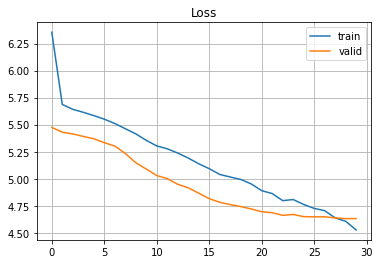

In [20]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
seq2seq.load_state_dict(torch.load('./saved_models/seq2seq.pt').get('model'))
test_loss = valid_step(seq2seq, criterion, test_iterator,
                       sos_index=EN.vocab.stoi[EN.init_token],
                       epoch_text='Test loss => ')

Test loss => Valid Loss: 4.641: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s]


# Inference